In [1]:
%matplotlib inline
import settings
from astropy.time import Time
import matplotlib.pyplot as plt
import numpy as np

from lasairmod import LasairError, lasair_client as lasair
import sys, time
import json
import scipy
from sympy import *
from ztfquery import lightcurve, query, metasearch
import scipy.stats as st
from scipy.stats import ks_2samp
from pandas.core.computation.check import NUMEXPR_INSTALLED

/Users/eleanorgallay/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/eleanorgallay/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/eleanorgallay/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


### Defining Functions

In [2]:
def diff_to_app_mag(ref_mag, alert_mag, sign): 
   
    """Function converts from difference magnitudes to apparent magnitudes. 
    
    Parameters
    ----------
    ref_mag : float
        Magnitude of reference source.
    alert_mag : float
        Difference magnitude of alert.
    sign : str
        Sign of the difference magnitude where
        t = positive difference magnitude = brightening
        f = negative difference magnitude = faintening.
        

    Returns
    -------
    app_mag
        Apparent magnitude as type ``float``.
    
    """
    if sign =='t': 
        app_mag = ((-2.5)*log((10**((-.4)*ref_mag)) + (10**((-.4)*alert_mag)),10))
    else:
        app_mag = ((-2.5)*log((10**((-.4)*ref_mag)) - (10**((-.4)*alert_mag)),10)) 
    
    return float(app_mag)

In [3]:
def app_mag_err_prop(ref_mag, alert_mag, sign, ref_err, alert_err):
    
    """Function propagates error when converting from difference magnitudes to apparent magnitudes. 
    
    Parameters
    ----------
    ref_mag : float
        Magnitude of reference source.
    
    alert_mag : float
        Difference magnitude of alert.
    
    sign : str
        Sign of the difference magnitude where
        t = positive difference magnitude = brightening
        f = negative difference magnitude = faintening.
    
    ref_err : float
        1-sigma uncertainty in reference magnitude.
   
    alert_err : float
        1-sigma uncertainty in alert magnitude.
        

    Returns
    -------
    app_err
        Apparent magnitude error as type ``float``.
    
    """
    
    
    r, a= symbols('r a', real=True) # Defines variables r (reference mag) and a (alert mag)
    
    if sign =='t': 
        f = ((-2.5)*log((10**((-.4)*r)) + (10**((-.4)*a)),10))
    else:
        f = ((-2.5)*log((10**((-.4)*r)) - (10**((-.4)*a)),10)) 
    
    
    # f = diff_to_app_mag(ref_mag, alert_mag, sign)
    
    d_ref = diff(f, r).subs([(a, alert_mag), (r, ref_mag)])         # Partial derivative of f with respect to r
    d_alert = diff(f, a).subs([(a, alert_mag), (r, ref_mag)])       # Partial derivative of f with respect to a
    
    app_err = float(sqrt((((d_ref)**2)*((ref_err)**2))+(((d_alert)**2)*((alert_err)**2))))   # Error propagation formula
    
    return app_err

### Query for Disappearing Stars

In [4]:
jdnow = str(Time.now().jd)
days = str(50) # number of days 

selected = '*'


tables = 'objects,sherlock_classifications'


conditions = """
objects.objectId=sherlock_classifications.objectId
AND (objects.sgscore1 > 0.9)
AND (sherlock_classifications.classification != "SN")
AND (sherlock_classifications.classification != "NT")
AND (sherlock_classifications.classification != "AGN")
AND (objects.ncand >= 10)
AND (sherlock_classifications.catalogue_table_name LIKE "%gaia%")
AND (objects.objectId LIKE "ZTF24%")
AND sherlock_classifications.separationArcsec < 0.5
AND ((objects.sgmag1 < 16)
   OR (objects.srmag1 < 16))
AND ISNULL(objects.ncandgp)
AND ("""+jdnow+"""- objects.jdmax) < """+days+"""

"""

L = lasair(settings.API_TOKEN, endpoint = "https://lasair-ztf.lsst.ac.uk/api")

try:
    v4 = L.query(selected, tables, conditions)
except LasairError as e:
    print(e)
    
print('Query returned ' + str(len(v4)) + ' candidates in the past '+ days + ' days')

Query returned 142 candidates in the past 50 days


### Plotting Light Curves from Alert Packet and ZTF archive 

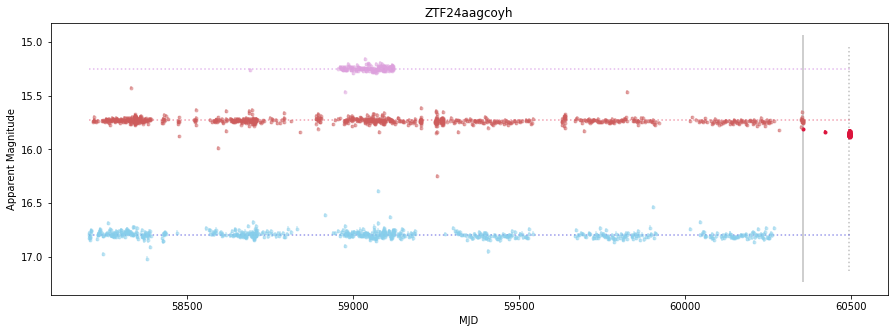

ZTF24aagcoyh r-band KS result: KstestResult(statistic=0.9917050691244239, pvalue=7.771561172376096e-16)

ZTF24aagcoyh r-band Chi Square statistic: 3.245717868116654
ZTF24aagcoyh r-band 5th - 95th percentile Chi Square statistic: 0.720338594844888

ZTF24aagcoyh has 64 alert packet data points
ZTF24aagcoyh has 1951 historic data points



/Users/eleanorgallay/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/eleanorgallay/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


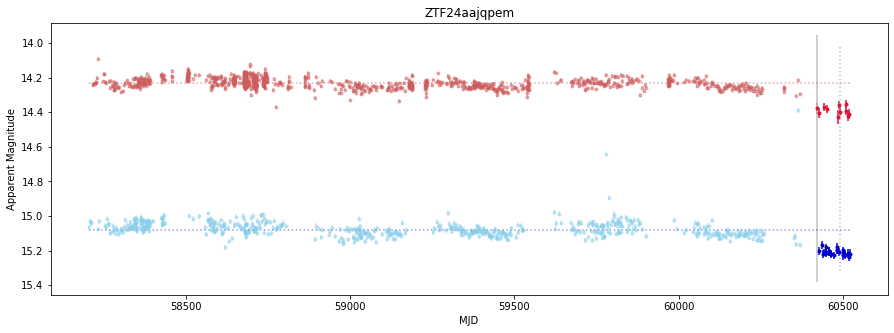

ZTF24aajqpem g-band KS result: KstestResult(statistic=1.0, pvalue=7.771561172376096e-16)
ZTF24aajqpem r-band KS result: KstestResult(statistic=0.9990714948932219, pvalue=2.220446049250313e-16)

ZTF24aajqpem g-band Chi Square statistic: 9.705610969508058
ZTF24aajqpem g-band 5th - 95th percentile Chi Square statistic: 3.890854650403502
ZTF24aajqpem r-band Chi Square statistic: 7.092167844448111
ZTF24aajqpem r-band 5th - 95th percentile Chi Square statistic: 4.180230613521961

ZTF24aajqpem has 37 alert packet data points
ZTF24aajqpem has 1638 historic data points



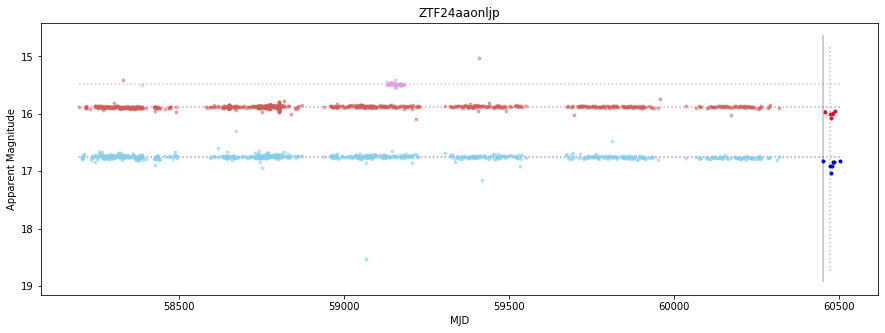

ZTF24aaonljp g-band KS result: KstestResult(statistic=0.9867197875166003, pvalue=7.974568376423186e-06)
ZTF24aaonljp r-band KS result: KstestResult(statistic=0.9908561928512053, pvalue=0.0002150507988585293)

ZTF24aaonljp g-band Chi Square statistic: 5.265067549257651
ZTF24aaonljp g-band 5th - 95th percentile Chi Square statistic: 0.5664029513282567
ZTF24aaonljp r-band Chi Square statistic: 6.817647674748998
ZTF24aaonljp r-band 5th - 95th percentile Chi Square statistic: 0.665363510632407

ZTF24aaonljp has 13 alert packet data points
ZTF24aaonljp has 1999 historic data points



/var/folders/39/_j5zssj14k9d0742tpg79j380000gn/T/ipykernel_58152/1934598961.py:106: RuntimeWarning: divide by zero encountered in divide
  variables['chisq_r'] = np.sum((((variables['rhist'] - np.median(variables['rhist'])) / variables['rhisterr'])**2 ) / float(len(variables['rhist'])))
/var/folders/39/_j5zssj14k9d0742tpg79j380000gn/T/ipykernel_58152/1934598961.py:106: RuntimeWarning: invalid value encountered in divide
  variables['chisq_r'] = np.sum((((variables['rhist'] - np.median(variables['rhist'])) / variables['rhisterr'])**2 ) / float(len(variables['rhist'])))
/var/folders/39/_j5zssj14k9d0742tpg79j380000gn/T/ipykernel_58152/1934598961.py:107: RuntimeWarning: divide by zero encountered in divide
  variables['chisq_r_5to95'] = np.sum((((variables['r_5to95'] - np.median(variables['r_5to95'])) / variables['rerr_5to95'])**2 ) / float(len(variables['r_5to95'])))
/var/folders/39/_j5zssj14k9d0742tpg79j380000gn/T/ipykernel_58152/1934598961.py:107: RuntimeWarning: invalid value encounter

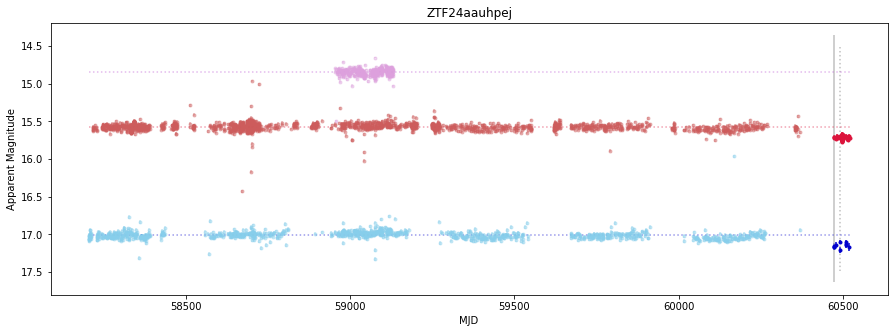

ZTF24aauhpej g-band KS result: KstestResult(statistic=0.9894829097283085, pvalue=5.109386780333125e-08)
ZTF24aauhpej r-band KS result: KstestResult(statistic=0.9942093541202672, pvalue=2.528401570435895e-18)

ZTF24aauhpej g-band Chi Square statistic: 5.942266076813613
ZTF24aauhpej g-band 5th - 95th percentile Chi Square statistic: 1.5685132535660333
ZTF24aauhpej r-band Chi Square statistic: 7.887514599262101
ZTF24aauhpej r-band 5th - 95th percentile Chi Square statistic: 3.0290768622810025

ZTF24aauhpej has 502 alert packet data points
ZTF24aauhpej has 3708 historic data points

138 candidates rejected
4 candidates remain


In [6]:
Dips= L.objects([row['objectId'] for row in v4])
lc = {}
candidates = []
trash = []

for obj in Dips:
    try:
        lc[obj['objectId']] = {'candidates': obj['candidates']}
    except TypeError:
        print('no')
    
    # Creating dictionary of variables
    variables = {}
    
    # Pulling historic ZTF light curve
    ztf = lightcurve.LCQuery.from_position(obj['objectData']['ramean'], obj['objectData']['decmean'], 1)
    
    # Defining arrays of ZTF historic magnitudes for each filter
    ztf_gsamp = np.array(ztf.data['mag'][ztf.data['filtercode'] == 'zg'][ztf.data['mjd'] < obj['objectData']['discMjd']])
    ztf_rsamp = np.array(ztf.data['mag'][ztf.data['filtercode'] == 'zr'][ztf.data['mjd'] < obj['objectData']['discMjd']])
    ztf_isamp = np.array(ztf.data['mag'][ztf.data['filtercode'] == 'zi'][ztf.data['mjd'] < obj['objectData']['discMjd']])
    
    # same for magnitude errors
    ztf_gerr = np.array(ztf.data['magerr'][ztf.data['filtercode'] == 'zg'][ztf.data['mjd'] < obj['objectData']['discMjd']])
    ztf_rerr = np.array(ztf.data['magerr'][ztf.data['filtercode'] == 'zr'][ztf.data['mjd'] < obj['objectData']['discMjd']])
    ztf_ierr = np.array(ztf.data['magerr'][ztf.data['filtercode'] == 'zi'][ztf.data['mjd'] < obj['objectData']['discMjd']])
    
    # ...and dates
    ztf_gmjd = np.array(ztf.data['mjd'][ztf.data['filtercode'] == 'zg'][ztf.data['mjd'] < obj['objectData']['discMjd']])
    ztf_rmjd = np.array(ztf.data['mjd'][ztf.data['filtercode'] == 'zr'][ztf.data['mjd'] < obj['objectData']['discMjd']])
    ztf_imjd = np.array(ztf.data['mjd'][ztf.data['filtercode'] == 'zi'][ztf.data['mjd'] < obj['objectData']['discMjd']])
    
    # calculating 5th - 95th percentile ranges for historic data 
    if len(ztf_gsamp) > 0:
        variables['ghist'] = ztf_gsamp[(obj['objectData']['discMjd'] - ztf_gmjd) > 100] # restricting data to 100 days before discovery date
        variables['ghisterr'] = ztf_gerr[(obj['objectData']['discMjd'] - ztf_gmjd) > 100]
        variables['g_p5'] = np.percentile(variables['ghist'], 5)
        variables['g_p95'] = np.percentile(variables['ghist'], 95)
        variables['g_5to95'] = variables['ghist'][(variables['ghist'] > variables['g_p5']) & (variables['ghist'] < variables['g_p95'])]
        variables['gerr_5to95'] = variables['ghisterr'][(variables['ghist'] > variables['g_p5']) & (variables['ghist'] < variables['g_p95'])]
    
    if len(ztf_rsamp) > 0:
        variables['rhist'] = ztf_rsamp[(obj['objectData']['discMjd'] - ztf_rmjd) > 100] # restricting data to 100 days before discovery date
        variables['rhisterr'] = ztf_rerr[(obj['objectData']['discMjd'] - ztf_rmjd) > 100]
        variables['r_p5'] = np.percentile(variables['rhist'], 5)
        variables['r_p95'] = np.percentile(variables['rhist'], 95)
        variables['r_5to95'] = variables['rhist'][(variables['rhist'] > variables['r_p5']) & (variables['rhist'] < variables['r_p95'])]
        variables['rerr_5to95'] = variables['rhisterr'][(variables['rhist'] > variables['r_p5']) & (variables['rhist'] < variables['r_p95'])]
    
    if len(ztf_isamp) > 0:
        variables['ihist'] = ztf_isamp[(obj['objectData']['discMjd'] - ztf_imjd) > 100] # restricting data to 100 days before discovery date
        variables['ihisterr'] = ztf_ierr[(obj['objectData']['discMjd'] - ztf_imjd) > 100]
        variables['i_p5'] = np.percentile(variables['ihist'], 5)
        variables['i_p95'] = np.percentile(variables['ihist'], 95)
        variables['i_5to95'] = variables['ihist'][(variables['ihist'] > variables['i_p5']) & (variables['ihist'] < variables['i_p95'])]
        variables['ierr_5to95'] = variables['ihisterr'][(variables['ihist'] > variables['i_p5']) & (variables['ihist'] < variables['i_p95'])]
    
    # Creating empty lists for each ZTF filter-band to be filled with apparent magnitudes and errors from alert packet
    gmag = []
    rmag = []
    imag = []
    
    gerr = []
    rerr = []
    ierr = []
    
    gmjd = []
    rmjd = []
    imjd = []
    alertmjd = []
    
    for alert in lc[obj['objectId']]['candidates']:
        if 'isdiffpos' in alert:
            variables['app_mag'] = diff_to_app_mag(alert['magnr'], alert['magpsf'], alert['isdiffpos']) # calculating apparent magnitude 
            variables['app_err'] = app_mag_err_prop(alert['magnr'], alert['magpsf'], alert['isdiffpos'], alert['sigmagnr'], alert['sigmapsf']) # propagating error
            alertmjd.append(alert['mjd'])
            
            # appending magnitudes and errors in each filter to their respective lists
            if alert['fid']== 1:
                gmag.append(variables['app_mag'])
                gerr.append(variables['app_err'])
                gmjd.append(alert['mjd'])
            if alert['fid']== 2:
                rmag.append(variables['app_mag'])
                rerr.append(variables['app_err'])
                rmjd.append(alert['mjd'])
            if alert['fid']== 3:
                imag.append(variables['app_mag'])
                ierr.append(variables['app_err'])
                imjd.append(alert['mjd'])
    
    
    # Restricting alert epoch magnitudes to data observed at least 30 days after the discovery date in Lasair
    alert_gsamp = np.array(gmag)[(np.array(gmjd) - obj['objectData']['discMjd']) >= 30]
    alert_rsamp = np.array(rmag)[(np.array(rmjd) - obj['objectData']['discMjd']) >= 30]
    alert_isamp = np.array(imag)[(np.array(imjd) - obj['objectData']['discMjd']) >= 30]
    
    # Performing K-S test with 95% confidence interval and calculating chi square statistic for each filter
    if len(alert_gsamp) > 0 and len(variables['ghist']) > 0:
        variables['KS_g'] = st.ks_2samp(alert_gsamp, variables['ghist'])
        variables['chisq_g'] = np.sum((((variables['ghist'] - np.median(variables['ghist'])) / variables['ghisterr'])**2 ) / float(len(variables['ghist'])))
        variables['chisq_g_5to95'] = np.sum((((variables['g_5to95'] - np.median(variables['g_5to95'])) / variables['gerr_5to95'])**2 ) / float(len(variables['g_5to95'])))
            
    if len(alert_rsamp) > 0 and len(variables['rhist']) > 0:  
        variables['KS_r'] = st.ks_2samp(alert_rsamp, variables['rhist'])
        variables['chisq_r'] = np.sum((((variables['rhist'] - np.median(variables['rhist'])) / variables['rhisterr'])**2 ) / float(len(variables['rhist'])))
        variables['chisq_r_5to95'] = np.sum((((variables['r_5to95'] - np.median(variables['r_5to95'])) / variables['rerr_5to95'])**2 ) / float(len(variables['r_5to95'])))

    if len(alert_isamp) > 0 and len(variables['ihist']) > 0: 
        variables['KS_i'] = st.ks_2samp(alert_isamp, variables['ihist'])
        variables['chisq_i'] = np.sum((((variables['ihist'] - np.median(variables['ihist'])) / variables['ihisterr'])**2 ) / float(len(variables['ihist'])))
        variables['chisq_i_5to95'] = np.sum((((variables['i_5to95'] - np.median(variables['i_5to95'])) / variables['ierr_5to95'])**2 ) / float(len(variables['i_5to95'])))
           
   
    # Imposing conditions that K-S test p-value is < 0.05 (95% confidence interval) and Chi square statistic is < 50
    g = True
    r = True
    i = True

    # if g true then there are alert samples, at least a hundred historic samples, and they meet the stats
    if len(gmag) > 0:
        g = False
        if len(alert_gsamp) > 0 and len(variables['ghist']) >= 100:
            g = (variables['KS_g'].pvalue < 0.05) and (np.median(alert_gsamp) > variables['g_p95']) and (variables['chisq_g'] < 10) and (variables['chisq_g_5to95'] < 5) 
    
    if len(rmag) > 0:
        r = False
        if len(alert_rsamp) > 0 and len(variables['rhist']) >= 100:
            r = (variables['KS_r'].pvalue < 0.05) and (np.median(alert_rsamp) > variables['r_p95']) and (variables['chisq_r'] < 10) and (variables['chisq_r_5to95'] < 5) 
            
    if len(imag) > 0:
        i = False
        if len(alert_isamp) > 0 and len(variables['ihist']) >= 100:
             i = (variables['KS_i'].pvalue < 0.05) and (np.median(alert_isamp) > variables['i_p95']) and (variables['chisq_i'] < 10) and (variables['chisq_i_5to95'] < 5) 
        
    if g and r and i:
        
        
        
        candidates.append(obj['objectId'])
        
        # Plotting
        plt.figure(figsize = (15, 5))
        plt.subplot(111)

        ga = plt.errorbar(gmjd, gmag, yerr = gerr, fmt = '.', color= 'mediumblue', label = 'g (alert)')
        ra = plt.errorbar(rmjd, rmag, yerr = rerr, fmt = '.', color= 'crimson', label = 'r (alert)')
        ia = plt.errorbar(imjd, imag, yerr = ierr, fmt = '.', color= 'mediumorchid', label = 'i (alert)')

        gh = plt.errorbar(ztf_gmjd, ztf_gsamp, yerr = ztf_gerr, fmt = '.', color= 'skyblue', alpha = 0.4, label = 'g (historic)')
        rh = plt.errorbar(ztf_rmjd, ztf_rsamp, yerr = ztf_rerr, fmt = '.', color= 'indianred', alpha = 0.4, label = 'r (historic)')
        ih = plt.errorbar(ztf_imjd, ztf_isamp, yerr = ztf_ierr, fmt = '.', color= 'plum', alpha = 0.4, label = 'i (historic)')

        mjdmin = plt.vlines(obj['objectData']['jdmin']-2400000.5, *plt.gca().get_ylim(), color='silver', linestyles=':', label='mjd min')  
        disc = plt.vlines(obj['objectData']['discMjd'], *plt.gca().get_ylim(), color='silver', label='disc date')
        gmed = plt.hlines(np.median(ztf_gsamp), np.min(ztf.data['mjd']), np.max(alertmjd), color='mediumblue', alpha= 0.4, linestyles=':', label='historic g-band median magnitude')
        rmed = plt.hlines(np.median(ztf_rsamp), np.min(ztf.data['mjd']), np.max(alertmjd), color='crimson', alpha= 0.4, linestyles=':', label='historic g-band median magnitude')
        imed = plt.hlines(np.median(ztf_isamp), np.min(ztf.data['mjd']), np.max(alertmjd), color='mediumorchid', alpha= 0.4, linestyles=':', label='historic g-band median magnitude')
        plt.gca().invert_yaxis()
        plt.ylabel('Apparent Magnitude')
        plt.xlabel('MJD')
        plt.title(obj['objectId'])
        plt.show()

        # Printing K-S test results
        if 'KS_g' in variables:
            print(obj['objectId']+' g-band KS result: '+ str(variables['KS_g']))

        if 'KS_r' in variables:  
            print(obj['objectId']+' r-band KS result: '+ str(variables['KS_r']))

        if 'KS_i' in variables: 
            print(obj['objectId']+' i-band KS result: '+ str(variables['KS_i']))

        print()

        # Printing Chi Square test results
        if 'chisq_g' in variables:
            print(obj['objectId']+' g-band Chi Square statistic: '+ str(variables['chisq_g']))
            print(obj['objectId']+' g-band 5th - 95th percentile Chi Square statistic: '+ str(variables['chisq_g_5to95']))

        if 'chisq_r' in variables:  
            print(obj['objectId']+' r-band Chi Square statistic: '+ str(variables['chisq_r']))
            print(obj['objectId']+' r-band 5th - 95th percentile Chi Square statistic: '+ str(variables['chisq_r_5to95']))

        if 'chisq_i' in variables: 
            print(obj['objectId']+' i-band Chi Square statistic: '+ str(variables['chisq_i']))
            print(obj['objectId']+' i-band 5th - 95th percentile Chi Square statistic: '+ str(variables['chisq_i_5to95']))

        print() 
        
        print(obj['objectId']+' has '+ str(len(gmag) + len(rmag) + len(imag))+ ' alert packet data points')
        print(obj['objectId']+' has '+ str(len(ztf.data['mag']))+ ' historic data points')
        
        print ()
        
    else:
        trash.append(obj['objectId'])
        
    variables.clear()
   
print(str(len(trash)) + ' candidates rejected')
print(str(len(candidates)) + ' candidates remain') 

Current criteria

Lasair query criteria:
- objects.sgscore1 > 0.9 (closer to 1 means the object is more likely to be a star than a galaxy)
- Object is not classified as a supernova, nuclear transient, nor active galactic nucleus by the sherlock classification scheme in Lasair
- Object has at least 10 data points in its alert packet
- Object has been crossmatched with the Gaia catalog
- Object is within 0.5 arcseconds of the best source match from sherlock
- Closest source match object is brighter than 16th magnitude in either g or r band
- Alert magnitudes are all fainter than the reference magnitude
- Alert occurred within the past 10 days
- Object's first alert happened in 2024

Further criteria:
- If object has alert data from a given filter, it must have at least 100 data points in its historic light curve from ZTF for that filter
- Object passes two-sample K-S test with a p-value less than 0.05 in every filter
- Object's historic data has a chi-square statistic less than 10
- Object's historic data that falls within the 5th to 95th percentile range has chi-square statistic less than 5
- Object's median alert magnitude is greater/fainter than the 95th percentile magnitude of the historic data in every filter

Note: K-S and chi square tests are calculated on historic data from over 100 days before the alert epoch and alert data from at least 30 days after the discovery date in Lasair

In [ ]:
# This could be added plot rejected candidates
#         if not (len(alert_gsamp) == 0 or len(ztf_gsamp) == 0 or KS_g.pvalue < 0.05):
#             print('failed g K-S test')
#         if not (len(alert_rsamp) == 0 or len(ztf_rsamp) == 0 or KS_r.pvalue < 0.05):
#             print('failed r K-S test')
#         if not (len(alert_isamp) == 0 or len(ztf_isamp) == 0 or KS_i.pvalue < 0.05):
#             print('failed i K-S test')
#         if not (len(alert_gsamp) == 0 or len(ztf_gsamp) == 0 or chisq_g < 50):
#             print('failed g Chi square test')
#         if not (len(alert_rsamp) == 0 or len(ztf_rsamp) == 0 or chisq_r < 50):
#             print('failed r Chi square test')
#         if not (len(alert_isamp) == 0 or len(ztf_isamp) == 0 or chisq_i < 50):
#             print('failed i Chi square test')     

#         # Plotting
#         plt.figure(figsize = (15, 5))
#         plt.subplot(111)

#         ga = plt.errorbar(gmjd, gmag, yerr = gerr, fmt = '.', color= 'darkgreen', label = 'g (alert)')
#         ra = plt.errorbar(rmjd, rmag, yerr = rerr, fmt = '.', color= 'red', label = 'r (alert)')
#         ia = plt.errorbar(imjd, imag, yerr = ierr, fmt = '.', color= 'indigo', label = 'i (alert)')

#         gh = plt.errorbar(ztf_gmjd, ztf_gsamp, yerr = ztf_gerr, fmt = '.', color= 'lightgreen', label = 'g (historic)')
#         rh = plt.errorbar(ztf_rmjd, ztf_rsamp, yerr = ztf_rerr, fmt = '.', color= 'lightcoral', label = 'r (historic)')
#         ih = plt.errorbar(ztf_imjd, ztf_isamp, yerr = ztf_ierr, fmt = '.', color= 'slateblue', label = 'i (historic)')

#         mjdmin = plt.vlines(obj['objectData']['jdmin']-2400000.5, *plt.gca().get_ylim(), color='lightgray', label='mjd min')  
#         disc = plt.vlines(obj['objectData']['discMjd'], *plt.gca().get_ylim(), color='lavender', label='disc date')
#         plt.gca().invert_yaxis()
#         plt.legend([gh, rh, ih, ga, ra, ia, disc, mjdmin], ['g (historic)', 'r (historic)', 'i (historic)', 'g (alert)', 'r (alert)', 'i (alert)', 'disc date', 'mjd min'], loc='upper left', ncol=3)
#         plt.ylabel('Apparent Magnitude')
#         plt.xlabel('mjd')
#         plt.title(obj['objectId'])
#         plt.show()

#         # Printing K-S test results
#         if len(alert_gsamp) > 0 and len(ztf_gsamp) > 0:
#             print(obj['objectId']+' g-band KS result: '+ str(KS_g))

#         if len(alert_rsamp) > 0 and len(ztf_rsamp) > 0:  
#             print(obj['objectId']+' r-band KS result: '+ str(KS_r))

#         if len(alert_isamp) > 0 and len(ztf_isamp) > 0: 
#             print(obj['objectId']+' i-band KS result: '+ str(KS_i))

#         print()

#         # Printing Chi Square test results
#         if len(alert_gsamp) > 0 and len(ztf_gsamp) > 0:
#             print(obj['objectId']+' g-band Chi Square statistic: '+ str(chisq_g))
#             #print(obj['objectId']+' g-band Chi Square critical value: '+ str(crit_g))

#         if len(alert_rsamp) > 0 and len(ztf_rsamp) > 0:  
#             print(obj['objectId']+' r-band Chi Square statistic: '+ str(chisq_r))
#             #print(obj['objectId']+' r-band Chi Square critical value: '+ str(crit_r))

#         if len(alert_isamp) > 0 and len(ztf_isamp) > 0: 
#             print(obj['objectId']+' i-band Chi Square statistic: '+ str(chisq_i))
#             #print(obj['objectId']+' i-band Chi Square critical value: '+ str(crit_i))

#         print() 